### Load Dataset and perform Exploratory Data Analysis:  

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_deposit():
    # Load csv dataset
    term_deposit_filepath = '../data/raw/term-deposit-marketing-2020.csv'
    #customer_survey_filepath = 'ACME-HappinessSurvey2020.csv'
    term_deposit = pd.read_csv(term_deposit_filepath)
    return term_deposit
term_deposit = load_deposit()

### Exploratory Data Analysis:  


In [7]:
term_deposit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
term_deposit.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [2]:
# Identify the categorical columns from the dataset.
categorical_cols = term_deposit.select_dtypes(include=['object']).columns
numerical_cols = term_deposit.select_dtypes(include=['int64']).columns

# Obtain unique values for each categorical column and count their occurrences for each column
category_summary = {col: term_deposit[col].value_counts().to_frame(name="count") for col in categorical_cols}
# Combine the summaries into a single dataframe for display
summary_combined = pd.concat(category_summary, axis=0)
summary_combined.index.names = ["feature", "category"]
print(summary_combined)

                         count
feature   category            
job       blue-collar     9383
          management      8166
          technician      6852
          admin           4483
          services        3910
          retired         1437
          self-employed   1414
          entrepreneur    1405
          unemployed      1104
          housemaid       1087
          student          524
          unknown          235
marital   married        24386
          single         10889
          divorced        4725
education secondary      20993
          tertiary       11206
          primary         6270
          unknown         1531
default   no             39191
          yes              809
housing   yes            24031
          no             15969
loan      no             33070
          yes             6930
contact   cellular       24914
          unknown        12765
          telephone       2321
month     may            13532
          jul             6380
        

#### Explore unknown values in dataset  

In [10]:
unknown_counts = (term_deposit == 'unknown').sum()
unknown_counts = unknown_counts[unknown_counts > 0]
unknown_counts

job            235
education     1531
contact      12765
dtype: int64

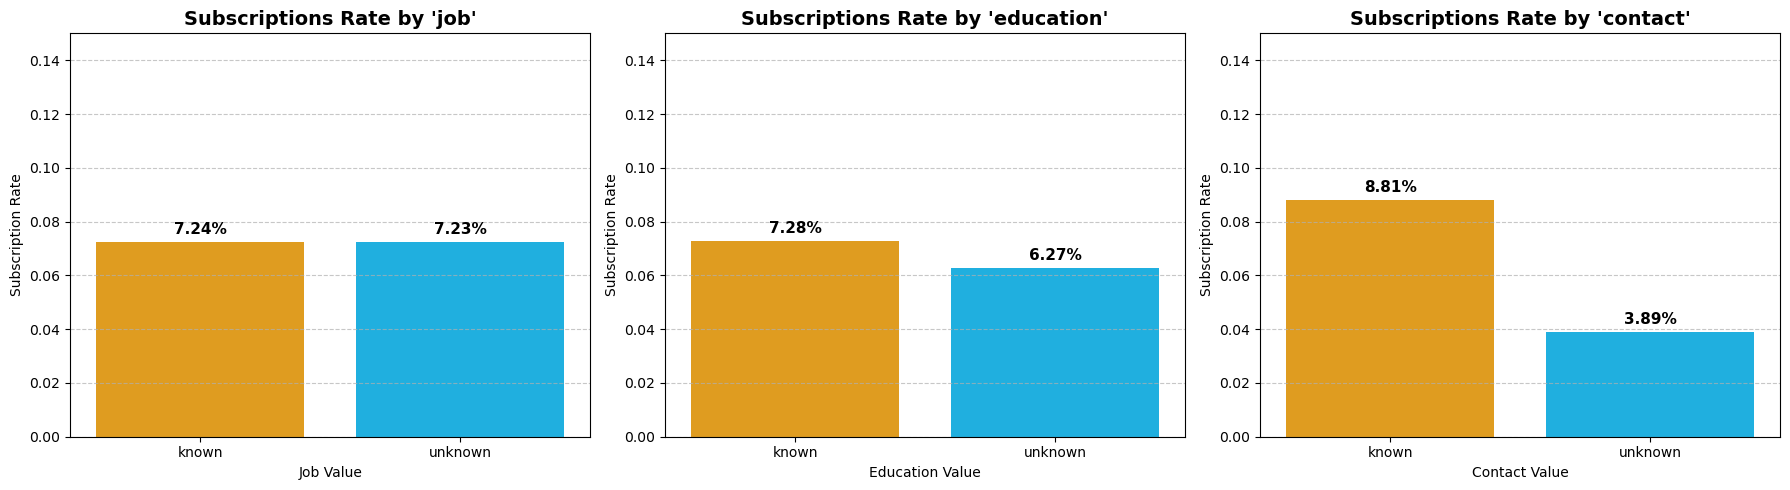

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_unknowns(term_deposit):
    unknown_deposit = term_deposit.copy()
    # Convert target to binary
    unknown_deposit["y"] = unknown_deposit["y"].map({"yes": 1, "no": 0})

    # features that contain unknown values
    unknown_features = ['job','education','contact']

    # loop creates new binary columns that indicate whether each row in a feature has unknown value
    """
    - Creates a new binary column for each feature (e.g., job_unknown)
    - True : if the row has value `unknown`
    - False : otherwise
    This allows comparsion between "known" vs "unknown" groups.
    """
    for feature in unknown_features:
        unknown_deposit[f"{feature}_unknown"] = unknown_deposit[feature] == 'unknown'

    # Create a 1x3 subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    # Plot success rates (proportion of y=1) for 'unknown' vs 'known' in each feature
    for i, feature in enumerate(unknown_features):
        col = f"{feature}_unknown"
        # compute the average of y (subscription) for each T/F group
        rate_term_deposit = unknown_deposit.groupby(col)["y"].mean().reset_index()
        # Relabel True and False
        rate_term_deposit[col] = rate_term_deposit[col].map({True: "unknown", False: "known"})

        ax = axes[i]
        ax = sns.barplot(data=rate_term_deposit, x=col, y="y", hue=col, palette=["orange", "deepskyblue"], legend=False, ax=ax)

         # Add percentage labels above bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.003,
                    f'{height * 100:.2f}%', ha="center", fontsize=11, fontweight='bold')
            
        ax.set_title(f"Subscriptions Rate by '{feature}'", fontsize=14, fontweight='bold')
        ax.set_ylabel('Subscription Rate')
        ax.set_xlabel(f'{feature.capitalize()} Value')
        ax.set_ylim(0,0.15)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_unknowns(term_deposit)

The percentage of unknown jobs for the category jobs is 0.6%. The total count of unknowns (235) is relatively small so I will keep these rows. From the subscription rate for known and unknown jobs, we see that people who do not disclose their jobs are slightly less likely to subscribe.  

Those with an unknown education have a lower subscription rate of 6.27% compared to known 7.28%. This significant lower subscription rate implies those with unknown education are less financially engaged or less responsive.  

Unknown contacts make up 32% which is a substantial amount of the contacts feature and would not be viable to be dropped from the dataset. Those with unknown contact means have a subscription rate of 3.89% compared to 8.81% This difference suggests that contact type is a meaningful signal. I will keep unknown as a valid level in one-hot encoding instead of imputing or removing this unknown values from the features.


#### Correlation heat map:  

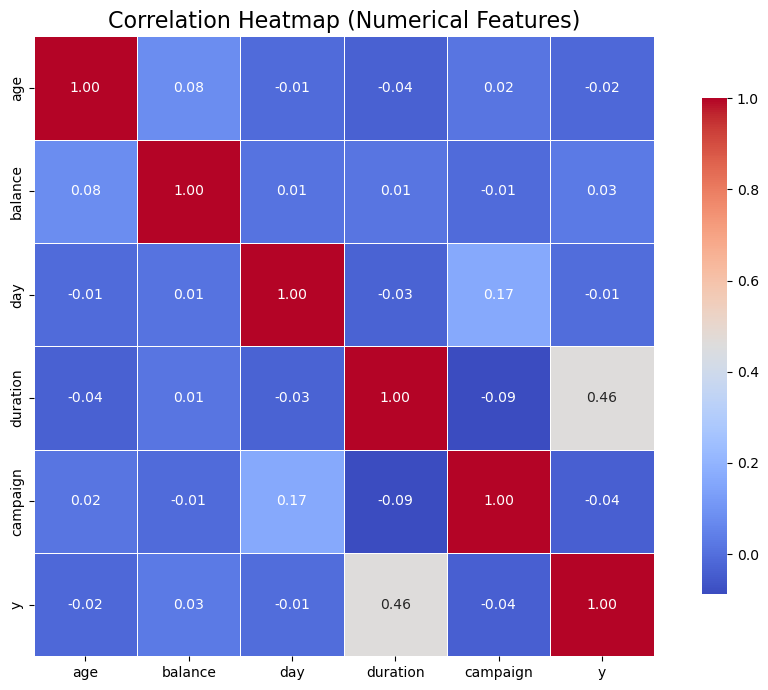

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# heatmap ofr 
def heatmap(term_deposit):
    correlation_deposit = term_deposit.copy()
    correlation_deposit['y'] = correlation_deposit['y'].map({'yes':1, 'no':0})
    correlation_matrix = correlation_deposit.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(10,7))

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidth=0.5,
        square=True,
        cbar_kws={'shrink':0.8},
        ax=ax
        )
    # Set Title
    ax.set_title("Correlation Heatmap (Numerical Features)", fontsize=16)
    # Adjust layout to prevent clipping
    fig.tight_layout()
    # Show plot
    plt.show()
heatmap(term_deposit)

There is notable correlation between duration and target variable. Very little correlations between each othe features, implies they are independent. No major colinearity among the freatures. 

#### Feature Distributions Numerical
The following plots display the skewness value, histogram shape and Q-Q plot shape for each of the numerical features in the dataset. Q-Q plots, histograms, and skewness values are used to understand the shape and symmetry of the feature distributions in order to decide how I would preprocess features before modeling. The histogram plots will show the distribution of values for the numerical features to give a visual overview of how a feature is spread across its range. The skewness value measures the asymmetry of a distribution. A normal distribution has a skewness ~ 0, a positive skew (right-skewed) visually has a long tail on the right (high values), and a negative skew (left-skewed) visually has a long tail on the left (low values). Quantile-Quantile (QQ) plots were utilized as a graphical tool to compare the distribution of the feature dataset against the normal distribution. Ideally the points should fall roughly on a straight line for the data to approximately be normally distributed. Some models (Logistic Regression, SVM and KNN) assume features are normally distributed and strong skewness or outliers can break these model’s performance.   

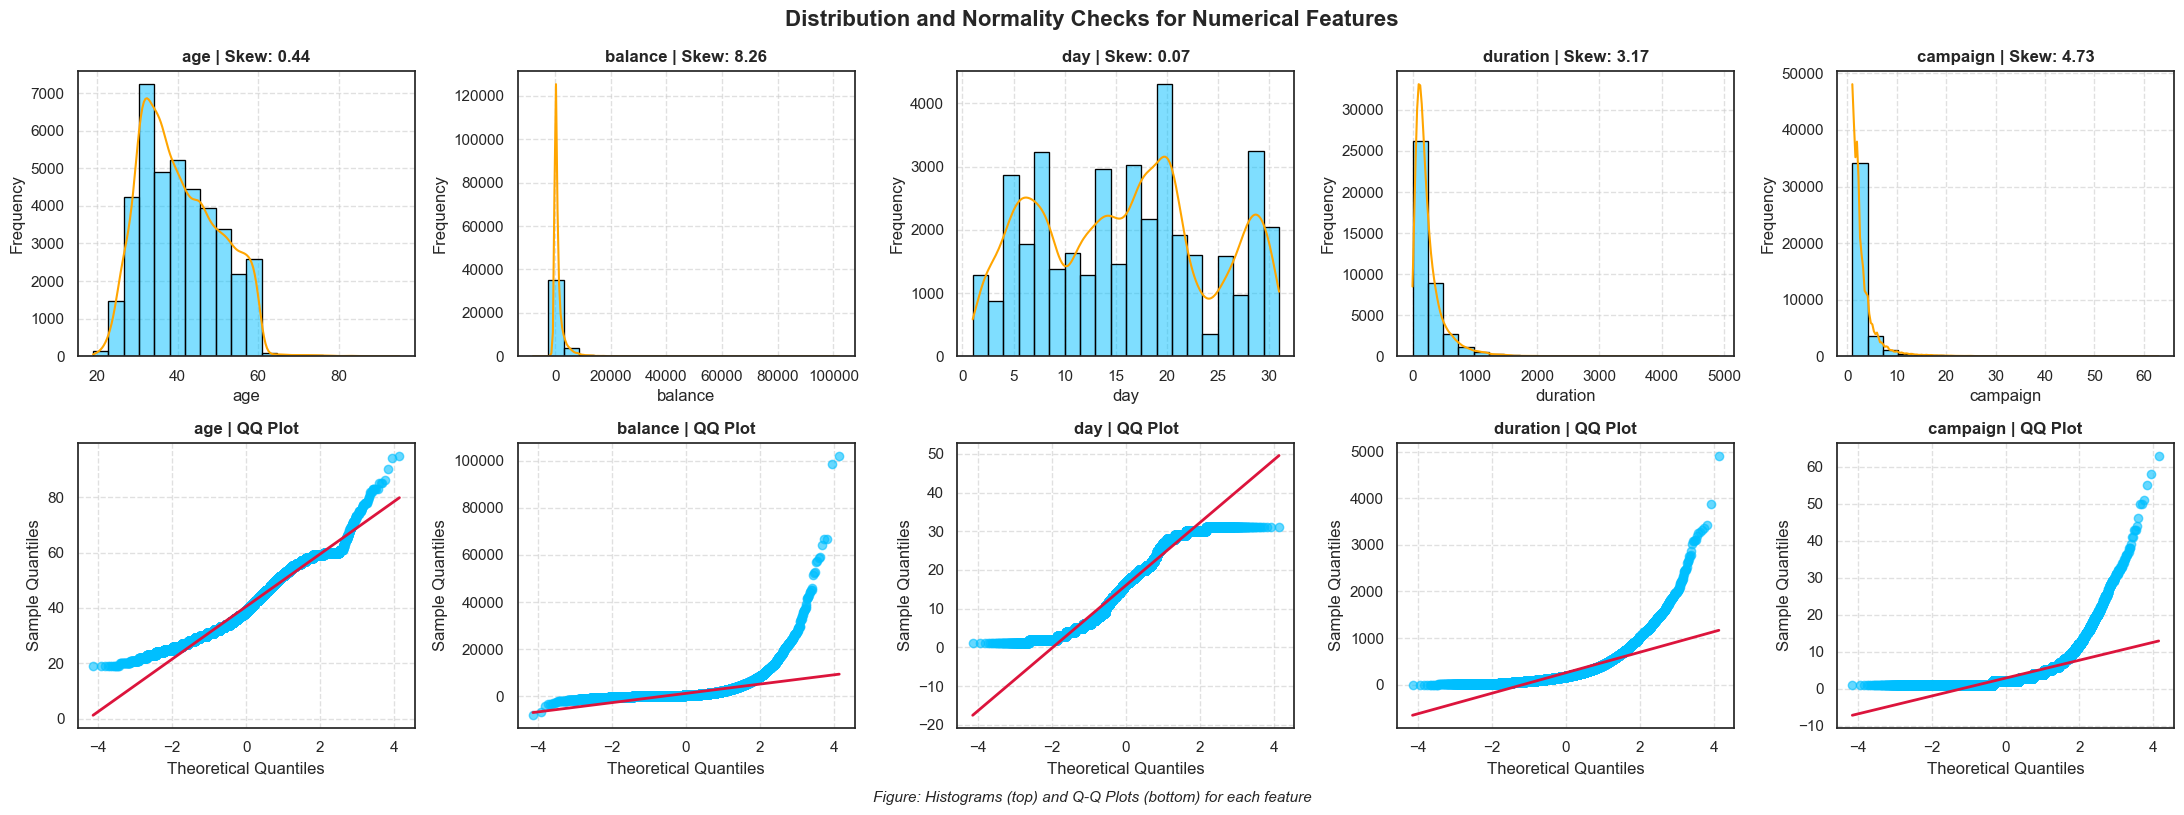

In [22]:
import scipy.stats as stats

# Updated function with bright blue QQ scatterpoints and custom KDE line
def check_skewness_and_qqplots(term_deposit, numerical_cols):
    sns.set_theme(style="white")
    fig, axes = plt.subplots(2,5, figsize=(22,8))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        skew_val = term_deposit[col].skew()

        # Histogram with KDE and custom colors
        sns.histplot(term_deposit[col], bins=20, kde=True, ax=axes[i],
                     color='deepskyblue', edgecolor='black', stat='count')

        # Modify KDE line color manually if present
        if axes[i].lines:
            axes[i].lines[0].set_color('orange')  # change KDE line color

        axes[i].set_title(f'{col} | Skew: {skew_val:.2f}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].grid(True, linestyle='--', alpha=0.6)

        # QQ Plot with bright blue scatterpoints and crimson line
        (osm, osr), (slope, intercept, r) = stats.probplot(term_deposit[col], dist="norm")

        axes[i+5].scatter(osm, osr, color='deepskyblue', alpha=0.6)
        axes[i+5].plot(osm, slope * osm + intercept, color='crimson', linewidth=2)
        axes[i+5].set_title(f'{col} | QQ Plot', fontsize=12, fontweight='bold')
        axes[i+5].set_xlabel("Theoretical Quantiles")
        axes[i+5].set_ylabel("Sample Quantiles")
        axes[i+5].grid(True, linestyle='--', alpha=0.6)

    # Adjust layout
    fig.suptitle("Distribution and Normality Checks for Numerical Features", fontsize=16, fontweight='bold')
    #fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.text(0.5, -0.01, 'Figure: Histograms (top) and Q-Q Plots (bottom) for each feature', 
             ha='center', fontsize=11, style='italic')
    plt.tight_layout()
    plt.show()

# Run the customized function
check_skewness_and_qqplots(term_deposit, numerical_cols)

The following can be gleaned for each numerical feature from the prior plots:  

* **age**:  The age variable histogram shows a small tail to the right with a mild slightly positive (right-skewed) value. Age’s QQ plot has the deviated points curving upward confirming the data is right-skewed. Most customers are in their 30s or middle aged with a tail to older years. Interpretation leads to this variable being almost normal with no transformations needed.  

* **balance**: Feature *balance*’s skewness value is very high (~8.9) and its histogram shows a long right tail with many small values and a few large outliers. The feature is strongly right skewed and its QQ plot having heavy S-shaped deviations in upper quantiles. Interpretation of these plots leads to the consideration of using log transformation to reduce skewness before modeling. Most customers have small to moderate balances, but few customers have very large balances pulling the distribution’s tail far to the right.  

* **day**: This variable has little to no skewness. The distribution of the days is fairly uniform across the month, with no strong pattern or bias toward the beginning or end.  

* **duration**: This feature has most of its values concentrated on the left with a sharp right tail. It has a high right-skewed value. From its QQ plot, it has a severe deviation from normality at higher values. Most calls are short but there are a few calls that are very long. Logarithmic transformation will be done on this feature with a cap on long calls to prevent distorting models.  

* **campaign**: Campaign has a high right-sided skewness value where the majority of the clients were contacted a few times and a few outliers were contacted 10+ times. The QQ plot affirms outliers affect the upper quantities. Will cap the long outliers to prevent noise.   


#### Feature Distributions Categorical

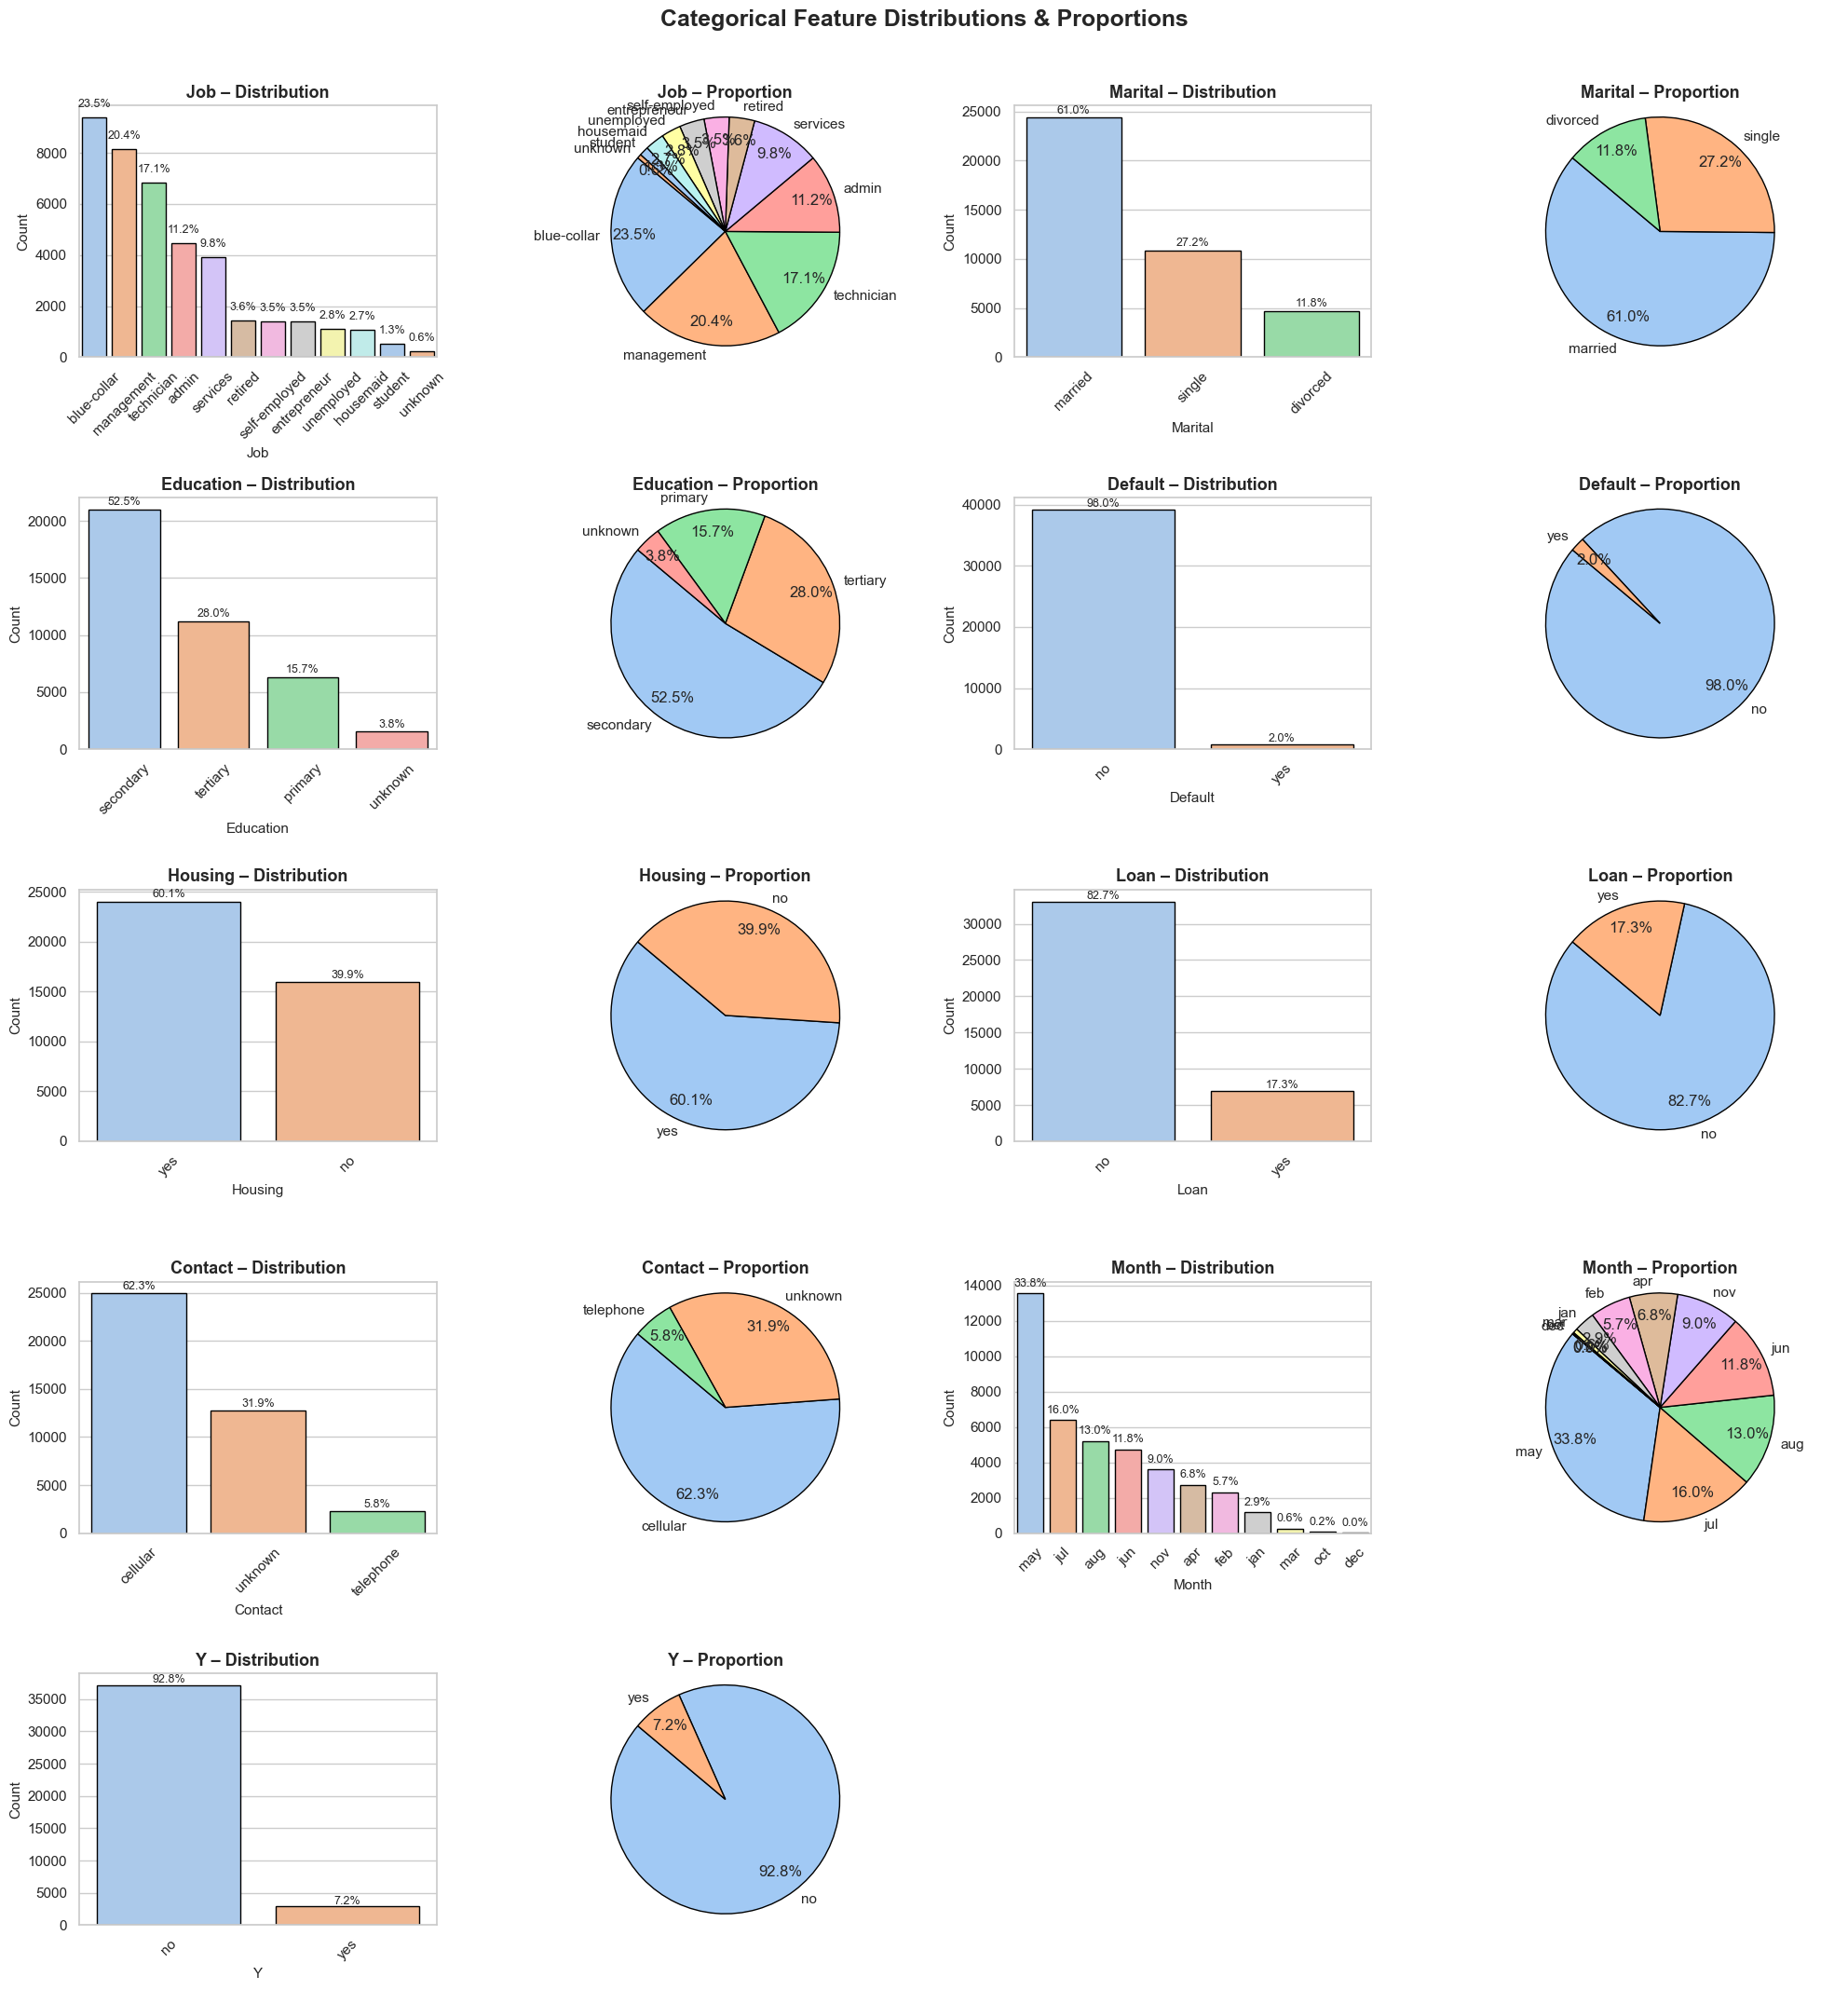

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')


# function to plot bar and pie charts for categorical features in the dataset
def plot_categorical_eda(term_deposit: pd.DataFrame ,categorical_cols: List[str]) -> None:
    """
    Plots bar and pie charts for categorical features in a 5x4 grid layout.
    Parameters:
    term_deposit : pd.DataFrame
        The dataset containing categorical features.
    categorical_cols : List[str]
        List of categorical column names to plot 
    """
    color_palette = sns.color_palette('pastel')
    # number of rows in dataset used to compute percentages
    total = len(term_deposit)
    num_features = len(categorical_cols)

    # Set up the 5x4 grid (each feature takes 2 plots: bar and pie)
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 22))
    axes = axes.flatten()

    # Main Plotting Loop
    for i, col in enumerate(categorical_cols):
        # assign bar+pie plots next to each other, 
        bar_ax = axes[2*i]
        pie_ax = axes[2*i+1]

        # Count of each category, preprocessing per column
        value_counts = term_deposit[col].value_counts()
        percentages = (value_counts / total * 100).round(1)

        # Bar Plot Construction
        sns.countplot(
            data=term_deposit,
            x=col,
            order=value_counts.index,
            palette=color_palette,
            ax = bar_ax,
            edgecolor='black'
        )
        # Add percentage labesl above bars
        for j, count in enumerate(value_counts):
            bar_ax.text(j, count + total * 0.01, f'{(count / total * 100):.1f}%', 
                        ha='center', fontsize=9)
        bar_ax.set_title(f'{col.capitalize()} – Distribution', fontsize=13, fontweight='bold')
        bar_ax.set_xlabel(col.capitalize(), fontsize=11)
        bar_ax.set_ylabel("Count", fontsize=11)
        bar_ax.tick_params(axis='x', rotation=45)

        # ---- Pie Chart ----
        pie_ax.pie(
            value_counts,
            labels=value_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.8,
            startangle=140,
            colors=color_palette,
            wedgeprops={'edgecolor': 'black'}
        )
        pie_ax.set_title(f'{col.capitalize()} – Proportion', fontsize=13, fontweight='bold')
        pie_ax.axis('equal')

    # Remove unused axes if any
    for idx in range(2 * num_features, len(axes)):
        fig.delaxes(axes[idx])

    fig.suptitle("Categorical Feature Distributions & Proportions", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.01, 1, 0.97])
    plt.show()
        
plot_categorical_eda(term_deposit, categorical_cols)

        





The following insights can be gleaned from the prior bar and pie charts of the categorical features: 
* **Y**: From the last plot, the distribution of the target variable is heavily imbalanced. Most customers did not subscribe to the term deposit with a subscription rate ~ 7%. Synthetic Minority Over-sampling Technique (SMOTE) will be utilized to handle the imbalance, and the evaluation metric will be adjusted to focus on F1-score instead of accuracy.  

* **Job**: The most common jobs are blue-collar, management, technician, admin and services. Students and retired customers are less frequent but are important as they often show higher subscription rates.

* **Marital**: Most customers are married (*61%*) followed by single and divorced. There is no major imbalance.

* **Education**: Over half of the customer base has a secondary level of education (*52.25%*), followed by tertiary, primary and lastly unknown. 

* **Default**: The vast majority of customers do not have default (96%). This feature is highly imbalanced.
 
* **Housing**: This feature is balanced, with ~60% of the customers having a housing loan. 

* **Loan**: Most customers do not have a personal loan (82.7%). This feature might be useful as having personal loans may impact financial flexibility.

* **Contact**: Majority of contact methods have been via cellular (623%) with unknown following and telephone having a small part. The unknown category is kept as it may indicate poor campaign reach.

* **Month**: From the plots, most calls are made in May, July, August and June. Months like January, March, October and December have very low marketing efforts. Seasonality is important and this feature will be cyclically encoded.


#### Detecting Outliers:  
Interquantile Range (IQR) was used to detect outliers for the numerical features. Many of the numerical features (balance, duration and campaign) are strongly skewed and not normally distributed from the histrogram and QQ plots. IQR focuses on the middle 50% of the data and ignores the extreme values on both ends. This makes it resistant to extreme outliers. 

In [3]:
# Outlier detection using IQR
# identifies and counts the number of outliers in each numerical column of the dataset using the Interquartile Range Method
def detect_outliers_iqr(term_deposit, numerical_cols):
    # compute the 25th and 75th percentile for each numerical column
    Q1 = term_deposit[numerical_cols].quantile(0.25)
    Q3 = term_deposit[numerical_cols].quantile(0.75)
    # calculates the Interquartile range "middle 50%"
    IQR = Q3 - Q1
    # threshold limits of an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # checks for each column which rows fall outside the bounds
    outliers = ((term_deposit[numerical_cols] < lower_bound) | (term_deposit[numerical_cols] > upper_bound)).sum()
    print(outliers[outliers>0])
    

detect_outliers_iqr(term_deposit,numerical_cols)


age           79
balance     4280
duration    3000
campaign    2992
dtype: int64


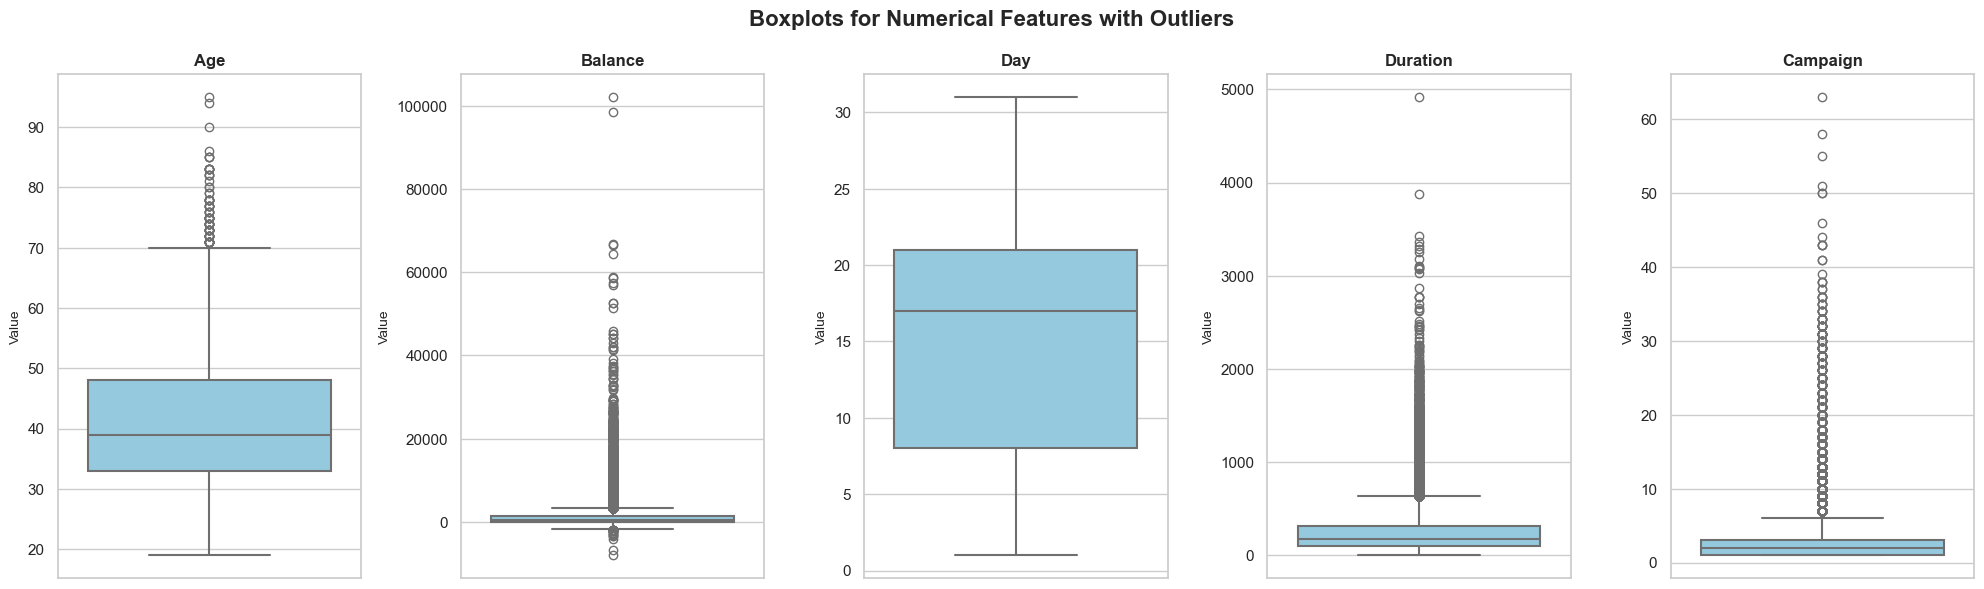

In [ ]:
# boxplot visualizing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_outliers(term_deposit, numerical_cols):
    sns.set_theme(style='whitegrid')
    
    #plt.figure(figsize=(8,4))
    num_features = len(numerical_cols)
    # create subplots, arrange boxplots horizontally (1 row, n columns)
    # each subplot is width 4, height 6, and sharey=False means each plot has it owns y-axis
    fig, axs = plt.subplots(1,num_features, figsize=(4 * num_features, 6), sharey=False)
    for i, num in enumerate(numerical_cols):
        sns.boxplot(y=term_deposit[num], ax=axs[i], color = 'skyblue', linewidth=1.5)
        axs[i].set_title(f"{num.capitalize()}", fontsize=12, fontweight='bold')
        axs[i].set_ylabel('Value', fontsize=10)
    fig.suptitle('Boxplots for Numerical Features with Outliers', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

boxplot_outliers(term_deposit, numerical_cols)

#### Overall Insights from numerical features boxplots
* Significant number of outliers in features: Balance, Duration and Campaign. These boxplots confirm from previous findings that these features will need transformation done to them. *Balance* contains negative values (overdrafts) which will be need to be shifted when log transformed as log transforming negative values produce NaN values which will crash machine learning models.
* The outliers in age are natural as there are older customers. Day has no significant outliers. 

### Preprocessing:  
##### One-hot Encoding to handle different data type features (categorical and numerical):  
One-hot encoding is a method to convert categorical features into a numerical format that machine learning models can utlizie. Simply assigning numbers to categories (e.g. job: 'staff' = 2, 'scientist' = 5) can mislead our ML models to think there is an ordinal relationship. The term deposit dataset shown above has 13 features and 40,000 data point of which 9 of the features are categorical. 


In [15]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_term_deposit(term_deposit, numerical_cols, categorical_cols):
    """
    Preprocess the Term Deposit Marketing Dataset based on prior EDA findings:
    Steps:
    - Encode the categorical featues (Label Encode for binary and One-Hot Encode for nominal using sklearn)
    - Log-transform skewed numerical variables
    - Cap extreme campaign values
    - Save transformed dataset to a CSV file
    Returns: features X and target Y
    """
    term_deposit = term_deposit.copy()
    categorical_cols = categorical_cols.drop('y', errors='ignore')

    # Target encoding, converting binary target (y) from ('yes', 'no') into (1,0)
    term_deposit['y'] = term_deposit['y'].map({'yes':1, 'no':0})

    # Separate Independent and Target Features
    y = term_deposit['y']
    term_deposit = term_deposit.drop('y', axis=1)   # Remove y to prevent it from being transformed

    # Log Transformation on skewed Numerical Featrues (balance & duration)
    # Balance has negative values, need to shift values to log transform them
    if 'balance' in term_deposit.columns:
        min_balance = term_deposit['balance'].min()
        shift_value = abs(min_balance) + 1 if min_balance <= -1 else 0
        term_deposit['balance'] = np.log1p(term_deposit['balance'] + shift_value)

    # Log transform duration
    if 'duration' in term_deposit.columns:
        term_deposit['duration'] = np.log1p(term_deposit['duration'])
    
    # Cap extreme values for campaign, cap number of times client contacted in campaign at 10
    if 'campaign' in term_deposit.columns:
        term_deposit['campaign'] = np.where(term_deposit['campaign'] > 10, 10, term_deposit['campaign'])

    # Label Encode Binary Categorical Features
    binary_features = ['default', 'housing', 'loan']
    for col in binary_features:
        if col in term_deposit.columns:
            term_deposit[col] = term_deposit[col].map({'yes':1, 'no':0})

    # One-Hot Encode Nominal Categorical Features
    # First filter only multi-class nominal features
    nominal_features = [col for col in categorical_cols if col not in binary_features and term_deposit[col].dtype == 'object']

    # Apply OneHotEncoder onto nominal_features, using sklearn
    encoder = ColumnTransformer(
        transformers=[
            # Drop first category to avoid multicollinearity, returns a dense array and keeps all non-encoded columns
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), nominal_features),
            ('scale', StandardScaler(), numerical_cols)
        ],
        remainder='passthrough'
    )

    # Apply the transformation using the defined pipeline
    transformed_term_deposit = encoder.fit_transform(term_deposit)
    # Get cleaned feature names by manually renaming columns after transformation
    feature_names = encoder.get_feature_names_out()
    feature_names = [name.split('__')[-1] for name in feature_names]
    transformed_term_deposit = pd.DataFrame(transformed_term_deposit, columns=feature_names)

    # Save the processed data
    processed_term = transformed_term_deposit.copy()
    processed_term['y'] = y.values
    output_path = '../data/interim/processed_term_deposit.csv'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    processed_term.to_csv(output_path, index=False)
    
    X = transformed_term_deposit.copy()
    return X, y

X, y = preprocess_term_deposit(term_deposit, numerical_cols, categorical_cols)

### Train/Test Split Transformed Dataset


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
